<h1>LSTM model</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                lstm_layers_unit_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_lstm_layers:",len(lstm_layers_unit_array))    
    for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):       
        print("lstm_layer_unit["+str(i)+"]; unit:"+str(lstm_layer_unit))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add LSTM layers
        for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):    
            model.add(LSTM(lstm_layer_unit, return_sequences=True))

        if len(lstm_layers_unit_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, number_of_features, 1))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         lstm_layers_unit_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        lstm_layers_unit_array=lstm_layers_unit_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))

In [5]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)



Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


<h3>Manual runs to get a feel of the hyperparameters</h3>

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:20
learningRate: 0.01
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devic

Epoch 24/40
752/752 [==============================] - 74s 99ms/step - loss: 0.8956 - accuracy: 0.6378 - precision: 0.7661 - recall: 0.4450 - val_loss: 0.9935 - val_accuracy: 0.5952 - val_precision: 0.7406 - val_recall: 0.3382
Epoch 25/40
752/752 [==============================] - 74s 99ms/step - loss: 0.8923 - accuracy: 0.6398 - precision: 0.7669 - recall: 0.4487 - val_loss: 0.9909 - val_accuracy: 0.5960 - val_precision: 0.7416 - val_recall: 0.3413
Epoch 26/40
752/752 [==============================] - 74s 99ms/step - loss: 0.8893 - accuracy: 0.6406 - precision: 0.7685 - recall: 0.4508 - val_loss: 0.9886 - val_accuracy: 0.5965 - val_precision: 0.7418 - val_recall: 0.3435
Epoch 27/40
752/752 [==============================] - 74s 99ms/step - loss: 0.8866 - accuracy: 0.6417 - precision: 0.7692 - recall: 0.4523 - val_loss: 0.9865 - val_accuracy: 0.5971 - val_precision: 0.7419 - val_recall: 0.3461
Epoch 28/40
752/752 [==============================] - 74s 99ms/step - loss: 0.8841 - accura

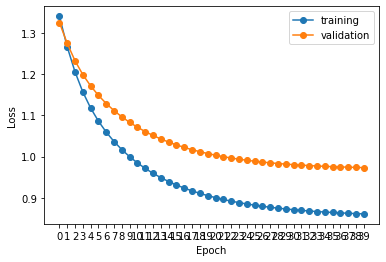

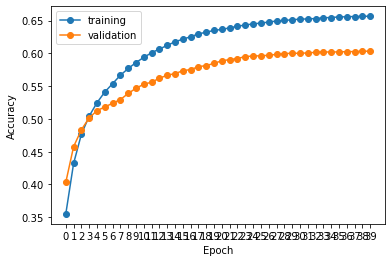

251/251 [==============================] - 12s 45ms/step - loss: 0.9523 - accuracy: 0.6193 - precision: 0.7647 - recall: 0.3743

Test Acc. 61.93%
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      1978
           1       0.64      0.65      0.65      1957
           2       0.62      0.71      0.66      2069
           3       0.59      0.51      0.55      2011

   micro avg       0.62      0.62      0.62      8015
   macro avg       0.62      0.62      0.62      8015
weighted avg       0.62      0.62      0.62      8015
 samples avg       0.62      0.62      0.62      8015

Confusion matrix
[[1186  342  215  235]
 [ 269 1279  212  197]
 [ 161  152 1464  292]
 [ 287  234  455 1035]]


In [8]:

train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.01,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_unit_array=[20]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:20
learningRate: 0.01
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: tanh
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
lstm (LSTM)                  (None, 3738, 20)          1760      
_________________________________________________________________
flatten (Flatten)            (None, 74760)             0         
_________________________________________________________________


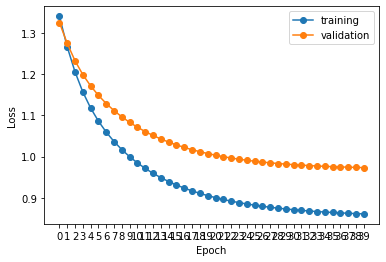

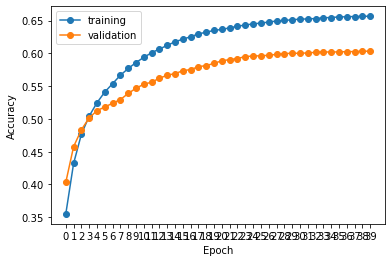

251/251 [==============================] - 12s 45ms/step - loss: 0.9523 - accuracy: 0.6193 - precision: 0.7647 - recall: 0.3743

Test Acc. 61.93%
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      1978
           1       0.64      0.65      0.65      1957
           2       0.62      0.71      0.66      2069
           3       0.59      0.51      0.55      2011

   micro avg       0.62      0.62      0.62      8015
   macro avg       0.62      0.62      0.62      8015
weighted avg       0.62      0.62      0.62      8015
 samples avg       0.62      0.62      0.62      8015

Confusion matrix
[[1186  342  215  235]
 [ 269 1279  212  197]
 [ 161  152 1464  292]
 [ 287  234  455 1035]]


In [14]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.01,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="tanh",
                     lstm_layers_unit_array=[20]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:5
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 5)           140       
_________________________________________________________________
flatten (Flatten)            (None, 18690)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 74764     
_________________________________________________________________


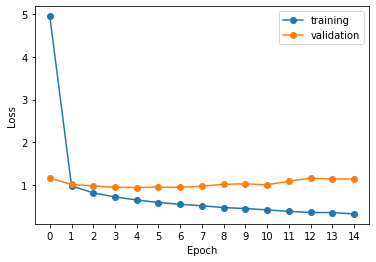

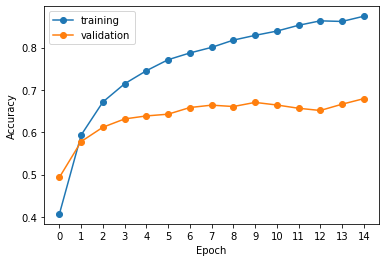

251/251 [==============================] - 12s 46ms/step - loss: 1.1657 - accuracy: 0.6736 - precision: 0.6864 - recall: 0.6609

Test Acc. 67.36%
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1978
           1       0.67      0.65      0.66      1957
           2       0.69      0.80      0.74      2069
           3       0.65      0.60      0.63      2011

   micro avg       0.67      0.67      0.67      8015
   macro avg       0.67      0.67      0.67      8015
weighted avg       0.67      0.67      0.67      8015
 samples avg       0.67      0.67      0.67      8015

Confusion matrix
[[1274  278  194  232]
 [ 263 1271  209  214]
 [ 121  110 1648  190]
 [ 253  226  326 1206]]


In [10]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_unit_array=[5]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_lstm_layers: 2
lstm_layer_unit[0]; unit:5
lstm_layer_unit[1]; unit:5
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 5)           140       
_________________________________________________________________
lstm_1 (LSTM)                (None, 3738, 5)           220       
_________________________________________________________________
flatten (Flatten)            (None, 18690)             0         
_______________________________________

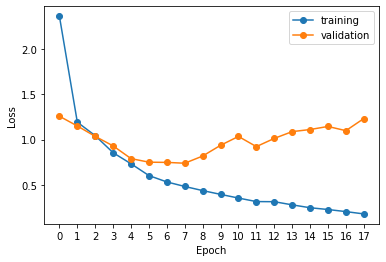

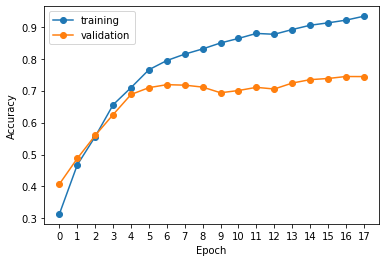

251/251 [==============================] - 22s 85ms/step - loss: 1.2549 - accuracy: 0.7385 - precision: 0.7429 - recall: 0.7336

Test Acc. 73.85%
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      1978
           1       0.78      0.69      0.73      1957
           2       0.80      0.79      0.80      2069
           3       0.69      0.73      0.71      2011

   micro avg       0.74      0.74      0.74      8015
   macro avg       0.74      0.74      0.74      8015
weighted avg       0.74      0.74      0.74      8015
 samples avg       0.74      0.74      0.74      8015

Confusion matrix
[[1466  185  103  224]
 [ 290 1342  115  210]
 [ 141   67 1643  218]
 [ 238  116  189 1468]]


In [11]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_unit_array=[5,5]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_lstm_layers: 2
lstm_layer_unit[0]; unit:10
lstm_layer_unit[1]; unit:5
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 10)          480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 3738, 5)           320       
_________________________________________________________________
flatten (Flatten)            (None, 18690)             0         
______________________________________

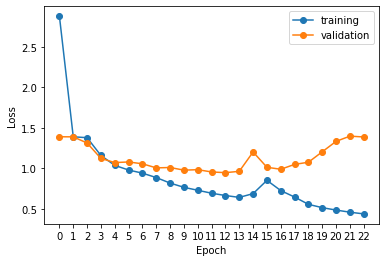

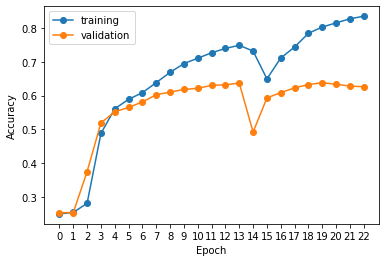

251/251 [==============================] - 22s 86ms/step - loss: 1.3711 - accuracy: 0.6374 - precision: 0.6486 - recall: 0.6240

Test Acc. 63.74%
              precision    recall  f1-score   support

           0       0.59      0.64      0.61      1978
           1       0.64      0.68      0.66      1957
           2       0.71      0.68      0.69      2069
           3       0.61      0.55      0.58      2011

   micro avg       0.64      0.64      0.64      8015
   macro avg       0.64      0.64      0.64      8015
weighted avg       0.64      0.64      0.64      8015
 samples avg       0.64      0.64      0.64      8015

Confusion matrix
[[1261  329  151  237]
 [ 331 1339  124  163]
 [ 215  156 1402  296]
 [ 336  264  304 1107]]


In [16]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_unit_array=[10,5]
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:256
learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 256)         264192    
_________________________________________________________________
flatten (Flatten)            (None, 956928)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3827716   
______________________________________________________________

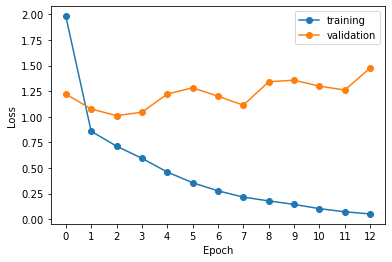

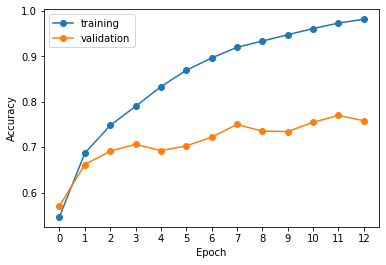

251/251 [==============================] - 16s 63ms/step - loss: 1.3860 - accuracy: 0.7657 - precision: 0.7690 - recall: 0.7629

Test Acc. 76.57%
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1978
           1       0.85      0.72      0.78      1957
           2       0.72      0.90      0.80      2069
           3       0.69      0.80      0.74      2011

   micro avg       0.77      0.77      0.77      8015
   macro avg       0.78      0.76      0.76      8015
weighted avg       0.78      0.77      0.76      8015
 samples avg       0.77      0.77      0.77      8015

Confusion matrix
[[1253  177  236  312]
 [ 118 1407  182  250]
 [  23   23 1864  159]
 [  51   42  305 1613]]


In [12]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_unit_array=[256]
                    )

<h3>Perform hyperparam tuning using the LSTM layer(s)</h3>

In [7]:
number_of_features = X_train.shape[1]

def model_tuner(hp):
    print("number_of_features:", number_of_features)
    
    # don't add any dense layer
    dense_layers_unit_array = []
    
    lstm_layers_unit_array=[]
    
    lstm_layers_unit_array_size = hp.Int('lstm_layers_unit_array_size', min_value=1, max_value=2, step=1)
    for i in range(lstm_layers_unit_array_size):
        lstm_layers_unit_array.append(hp.Int('lstm_layers_unit_'+str(i), 
                                                min_value=5, max_value=30, step=5))
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.001, 0.01, 0.05, 0.1]),
                activation=hp.Choice('activation', values=["tanh", "relu"]), 
                isBatchNormalized=hp.Choice("isBatchNormalized", values=[True, False]), 
                dropOutRate=hp.Float('dropOutRate', min_value=0, max_value=0.7, step=0.1),
                startWithBatchNormalized=hp.Choice("startWithBatchNormalized", values=[True, False]),      
                optimizer=hp.Choice("optimizer", values=["Adam", "SGD"]),
                lstm_layers_unit_array=lstm_layers_unit_array
                       )
    
    return model

In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

epochs = 40
tuner = kt.Hyperband(model_tuner,
                     objective='val_accuracy',
                     max_epochs=epochs,
                     factor=3,
                     directory='.',
                     seed=1234,
                     project_name='eeg')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")

print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))
print("lstm_layers_unit_array_size:",best_hps.get('lstm_layers_unit_array_size'))

try:
    print("lstm_layers_unit_0:",best_hps.get('lstm_layers_unit_0'))
except:
    print("no lstm layer 0")
    
try:
    print("lstm_layers_unit_1:",best_hps.get('lstm_layers_unit_1'))
except:
    print("no lstm layer 1")
  

print("dropOutRate:",best_hps.get('dropOutRate'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))

Trial 85 Complete [00h 29m 05s]
val_accuracy: 0.6975293159484863

Best val_accuracy So Far: 0.7651609778404236
Total elapsed time: 09h 41m 46s

Search: Running Trial #86

Hyperparameter    |Value             |Best Value So Far 
lstm_layers_uni...|2                 |1                 
lstm_layers_unit_0|25                |15                
learningRate      |0.1               |0.001             
activation        |relu              |tanh              
isBatchNormalized |0                 |1                 
dropOutRate       |0.4               |0.2               
startWithBatchN...|1                 |0                 
optimizer         |Adam              |Adam              
lstm_layers_unit_1|15                |10                
tuner/epochs      |40                |40                
tuner/initial_e...|14                |14                
tuner/bracket     |1                 |3                 
tuner/round       |1                 |3                 
tuner/trial_id    |7ff6573a868e

InvalidArgumentError: 3 root error(s) found.
  (0) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential/activation/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_41/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[replica_1/assert_less_equal/Assert/AssertGuard/branch_executed/_115/_339]]
  (1) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential/activation/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_41/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[div_no_nan_1/_147]]
  (2) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential/activation/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_41/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1626672]

Function call stack:
train_function -> train_function -> train_function


<h3>Hyperparams tunning crashed after 85 runs. But it seems the test accuracy only gets to 76% only still so probably won't able to get better. Run the model with that hyperparams found by the tuning to confirm test accuracy.</h3>

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 0
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.2
startWithBatchNormalized: False
optimizer: Adam ; activation: tanh
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 224284    
________________________________________________________________

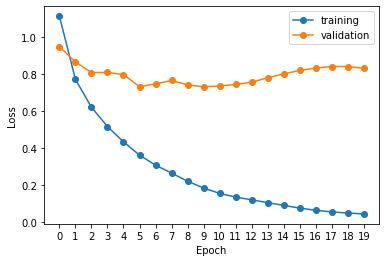

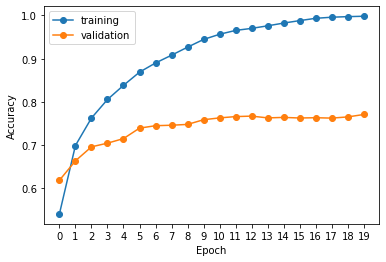

251/251 [==============================] - 12s 45ms/step - loss: 0.7914 - accuracy: 0.7823 - precision: 0.7913 - recall: 0.7745

Test Acc. 78.23%
              precision    recall  f1-score   support

           0       0.82      0.68      0.74      1978
           1       0.79      0.80      0.80      1957
           2       0.80      0.86      0.83      2069
           3       0.72      0.79      0.76      2011

   micro avg       0.78      0.78      0.78      8015
   macro avg       0.79      0.78      0.78      8015
weighted avg       0.78      0.78      0.78      8015
 samples avg       0.78      0.78      0.78      8015

Confusion matrix
[[1342  251  127  258]
 [ 117 1567  103  170]
 [  57   58 1770  184]
 [ 120   97  203 1591]]


In [9]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.2,
                     activation="tanh",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True
                    )

<h3>Conclusion</h3>

Hyperparam tuning on LSTM: 78.23% accuracy </br>
num_of_dense_layers: 0 </br>
num_of_lstm_layers: 1 </br>
lstm_layer_unit[0]; unit:15 </br>
learningRate: 0.001 </br>
isBatchNormalized: True </br>
dropOutRate: 0.2 </br>
startWithBatchNormalized: False </br>
optimizer: Adam </br>
activation doesn't matter since there is no dense layer. </br>
</br>

Manual tuning on LSTM: 76.57% accuracy </br>
num_of_dense_layers: 0 </br>
num_of_lstm_layers: 1 </br>
lstm_layer_unit[0]; unit:256 </br>
learningRate: 0.001 </br>
isBatchNormalized: False </br>
dropOutRate: 0.5 </br>
startWithBatchNormalized: False </br>
optimizer: Adam </br>
activation doesn't matter since there is no dense layer. </br>